In [1]:
import math
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten   
from tensorflow.keras.layers import Layer, ZeroPadding2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

### Helpers

In [2]:
# an implication of Pytorch CrossMapLRN2d with Keras
class LRN2D(Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5):
        if n % 2 == 0:
            raise NotImplementedError('LRN2D only works with odd n. n provided: ' + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = X.shape
        half_n = self.n // 2
        input_sqr = T.sqr(X)
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c)
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :], input_sqr)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        return {'name': self.__class__.__name__,
                'alpha': self.alpha,
                'k': self.k,
                'beta': self.beta,
                'n': self.n}

    

# another implication of Pytorch CrossMapLRN2d with Keras
class LocalResponseNormalization(Layer):
  
    def __init__(self, n=5, alpha=1e-4, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LocalResponseNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LocalResponseNormalization, self).build(input_shape)

    def call(self, x):
        _, r, c, f = self.shape 
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1,1), padding='same', pool_mode='avg')
        summed = K.sum(pooled, axis=3, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom 
    
    def compute_output_shape(self, input_shape):
        return input_shape



# Function for changing learning rate over epochs
def lr_decay(epoch):
    decay = .1
    lr = base_lr * math.pow(decay, (epoch // 30))   
    return lr


## **1. Data**

In [27]:
# read the pkl file and load the data
path = 'D:/ETE/Data/Data_Mini/'
pickles = ['images', 'left_eyes', 'right_eyes', 'faces', 'grids_mtcnn', 'grids_paper']

for pkl in tqdm(pickles):
    with open(path + pkl + '.pkl','rb') as f:
        exec(pkl + ' = pickle.load(f)')


### Test Data

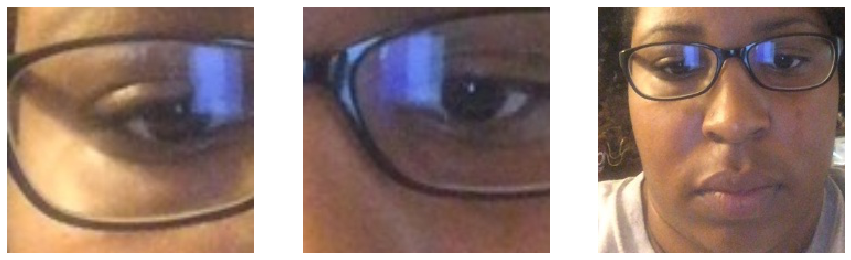

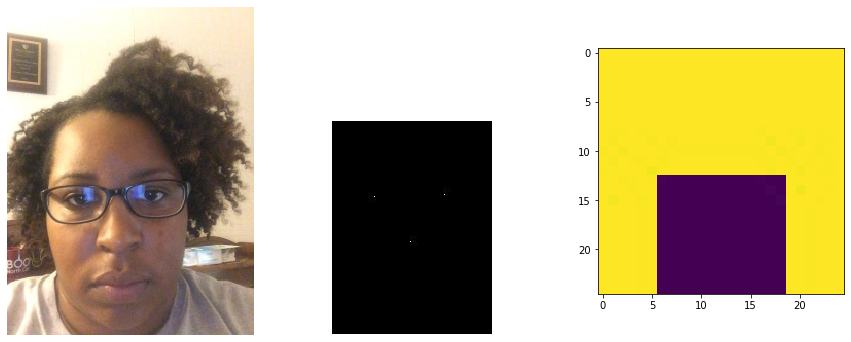

In [111]:
pickles = ['images', 'left_eyes', 'right_eyes', 'faces', 'grids_mtcnn', 'grids_paper']

#for pkl in pickles:
#    exec('print(pkl, \'is a\', type(' + pkl+ '), \'with shape:\', ' + pkl + '.shape)')

#idx = np.random.randint(9992)
idx = 27

fig, axs = plt.subplots(1, 3, figsize=(15,45))

for i in range(3):
    axs[i].axis('off')
axs[0].imshow(right_eyes[idx])
axs[1].imshow(left_eyes[idx])
axs[2].imshow(faces[idx])

fig, axs = plt.subplots(1, 3, figsize=(15,45))
for i in range(2):
    axs[i].axis('off')
axs[0].imshow(images[idx])
axs[1].imshow(grids_mtcnn[idx])
axs[2].imshow(grids_paper[idx]);

7636


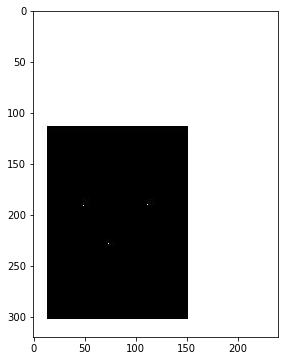

In [49]:
print(idx)
plt.figure(figsize=(10,6))
plt.imshow(grids_mtcnn[7636])

## **2. The Model**

### **Eye Net**

In [ ]:
eye_input = Input(shape=(224,224,3))
eye_cnn1_out = Conv2D(filters=96,
                       kernel_size=11,
                       strides=4,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4),
                       input_shape=(224,224,3))(eye_input)
eye_max1_out = MaxPool2D(pool_size=3, strides=2)(eye_cnn1_out)
eye_lrn1_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eye_max1_out)
eye_zro1_out = ZeroPadding2D(padding=2)(eye_lrn1_out)
eye_cnn2_out = Conv2D(filters=256,
                      kernel_size=5,
                      strides=1,
                      padding='valid',
                      #groups=2,
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(eye_zro1_out)
eye_max2_out = MaxPool2D(pool_size=3, strides=2)(eye_cnn2_out)
eye_lrn2_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eye_max2_out)
eye_cnn3_out = Conv2D(filters=384,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(eye_lrn2_out)
eye_cnn4_out = Conv2D(filters=64,
                      kernel_size=1,
                      strides=1,
                      padding='valid',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(eye_cnn3_out)
eye_out = Flatten()(eye_cnn4_out)

model_eye = Model(eye_input, eye_out)


### **Left Eye Net**

In [ ]:
eyel_input = Input(shape=(224,224,3))
eyel_cnn1_out = Conv2D(filters=96,
                       kernel_size=11,
                       strides=4,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4),
                       input_shape=(224,224,3))(eyel_input)
eyel_max1_out = MaxPool2D(pool_size=3, strides=2)(eyel_cnn1_out)
eyel_lrn1_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eyel_max1_out)
eyel_zro1_out = ZeroPadding2D(padding=2)(eyel_lrn1_out)
eyel_cnn2_out = Conv2D(filters=256,
                       kernel_size=5,
                       strides=1,
                       padding='valid',
                       #groups=2,
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyel_zro1_out)
eyel_max2_out = MaxPool2D(pool_size=3, strides=2)(eyel_cnn2_out)
eyel_lrn2_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eyel_max2_out)
eyel_cnn3_out = Conv2D(filters=384,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyel_lrn2_out)
eyel_cnn4_out = Conv2D(filters=64,
                       kernel_size=1,
                       strides=1,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyel_cnn3_out)
eyel_out = Flatten()(eyel_cnn4_out)


### **Right Eye Net**

In [ ]:
eyer_input = Input(shape=(224,224,3))
eyer_cnn1_out = Conv2D(filters=96,
                       kernel_size=11,
                       strides=4,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4),
                       input_shape=(224,224,3))(eyer_input)
eyer_max1_out = MaxPool2D(pool_size=3, strides=2)(eyer_cnn1_out)
eyer_lrn1_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eyer_max1_out)
eyer_zro1_out = ZeroPadding2D(padding=2)(eyer_lrn1_out)
eyer_cnn2_out = Conv2D(filters=256,
                       kernel_size=5,
                       strides=1,
                       padding='valid',
                       #groups=2,
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyer_zro1_out)
eyer_max2_out = MaxPool2D(pool_size=3, strides=2)(eyer_cnn2_out)
eyer_lrn2_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(eyer_max2_out)
eyer_cnn3_out = Conv2D(filters=384,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyer_lrn2_out)
eyer_cnn4_out = Conv2D(filters=64,
                       kernel_size=1,
                       strides=1,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(eyer_cnn3_out)
eyer_out = Flatten()(eyer_cnn4_out)


### **Face Net**

In [ ]:
face_input = Input(shape=(224,224,3))
face_cnn1_out = Conv2D(filters=96,
                       kernel_size=11,
                       strides=4,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4),
                       input_shape=(224,224,3))(face_input)
face_max1_out = MaxPool2D(pool_size=3, strides=2)(face_cnn1_out)
face_lrn1_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(face_max1_out)
face_zro1_out = ZeroPadding2D(padding=2)(face_lrn1_out)
face_cnn2_out = Conv2D(filters=256,
                       kernel_size=5,
                       strides=1,
                       padding='valid',
                       #groups=2,
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(face_zro1_out)
face_max2_out = MaxPool2D(pool_size=3, strides=2)(face_cnn2_out)
face_lrn2_out = LRN2D(n=5, alpha=1e-4, beta=0.75, k=1.0)(face_max2_out)
face_cnn3_out = Conv2D(filters=384,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(face_lrn2_out)
face_cnn4_out = Conv2D(filters=64,
                       kernel_size=1,
                       strides=1,
                       padding='valid',
                       activation='relu',
                       kernel_regularizer=regularizers.l2(1e-4))(face_cnn3_out)
face_flt_out = Flatten()(face_cnn4_out)
face_dns_out = Dense(128, activation = 'relu',
                     kernel_regularizer=regularizers.l2(1e-4))(face_flt_out)
face_out = Dense(64, activation = 'relu')(face_dns_out)


### **Grid Net**

In [ ]:
grid_input = Input(shape=(25,25))
grid_flt_out = Flatten()(grid_input)
grid_dns_out = Dense(256, activation = 'relu',
                     kernel_regularizer=regularizers.l2(1e-4))(grid_flt_out)
grid_out = Dense(128, activation = 'relu',
                 kernel_regularizer=regularizers.l2(1e-4))(grid_dns_out)


### **Merge the Eyes' Nets**

In [ ]:
eye_left_input = Input(shape=(224,224,3))
eye_right_input = Input(shape=(224,224,3))
eye_left_out = model_eye(eye_left_input)
eye_right_out = model_eye(eye_right_input)

concat_eyes = concatenate([eye_left_out, eye_right_out])

eyes_out = Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(concat_eyes)
#model_eyes = Model([eye_left_input, eye_right_input], model_eyes_out)


### **Merge the Eyes, Face, and the Grid Nets**

In [ ]:
concat_all = concatenate([eyes_out, face_out, grid_out])

final_dns_out = Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(concat_all)
final_out = Dense(2, activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(final_dns_out)

final_model = Model([eye_left_input, eye_right_input, face_input, grid_input], final_out)


## **3. Training**

In [ ]:
lr_callback = LearningRateScheduler(lr_decay)
checkpointer = ModelCheckpoint(filepath='Weights.hdf5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
base_lr = 0.0001
momentum = 0.9

sgd = SGD(lr=base_lr, momentum=momentum)

In [ ]:
final_model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

final_model.fit(x=[left_eyes, right_eyes, faces, grids], 
          y=labels,
          # batch_size=256, # for the complete dataset
          batch_size=32,
          epochs=25,
          # validation_data=(val_images, val_labels) # for the complete dataset  
          validation_split=0.2,
          shuffle=True,
          callbacks=[lr_callback, checkpointer])